In [83]:
from collections import Counter
import nltk
import pandas as pd
from emoticons import EmoticonDetector
import re as regex
import numpy as np
import plotly
from plotly import graph_objs
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from time import time
import gensim

import matplotlib.pyplot as plt
%matplotlib inline

# plotly configuration
plotly.offline.init_notebook_mode()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [131]:
class Data_Initialize():
    data = []
    processed_data = []
    wordlist = []

    data_model = None
    data_labels = None
    is_testing = False
    
    def initialize(self, csv_file, is_testing_set=False, from_cached=None):
        if from_cached is not None:
            self.data_model = pd.read_csv(from_cached)
            return

        self.is_testing = is_testing_set

        if not is_testing_set:
            self.data = pd.read_csv(csv_file, header=0, names=["idx","comment", "emotion", "date","url"])
            self.data = self.data[self.data["emotion"].isin(["positive", "negative"])]
        else:
            self.data = pd.read_csv(csv_file, header=0, names=["comment"],dtype={"comment":"str"},nrows=4000)
            not_null_text = 1 ^ pd.isnull(self.data["comment"])
            not_null_id = 1 ^ pd.isnull(self.data["idx"])
            self.data = self.data.loc[not_null_id & not_null_text, :]

        self.processed_data = self.data
        self.wordlist = []
        self.data_model = None
        self.data_labels = None

In [132]:
data = Data_Initialize()
data.initialize("data\\four-column500v1.2.csv")
data.processed_data.head(10)

,idx,comment,emotion,date,url
0,0,عسلامة أورونج رقدت مخلي ال puce متاعي أورونج ق...,negative,2018-01-02T19:16:17+0000,https://www.facebook.com/298166859034_10155976...
1,1,اورونج نحب نقلكم عيشكم خاتر انتوما الوحدين\nتت...,negative,2018-01-02T19:43:48+0000,https://www.facebook.com/298166859034_10155976...
2,2,"brabi orange, pk l'connexion ,ma@ t7ebech temc...",negative,2018-01-02T20:37:47+0000,https://www.facebook.com/298166859034_10155976...
3,3,slm orange elyoum 3adet fourfi 900 ta3 7 jour ...,negative,2018-01-02T19:00:49+0000,https://www.facebook.com/298166859034_10155976...
4,4,N7eb orange,positive,2018-01-08T20:13:49+0000,https://www.facebook.com/298166859034_10155991...
5,5,حزين,negative,2018-01-08T19:15:36+0000,https://www.facebook.com/298166859034_10155991...
6,6,نسالكم 70 ميغاا الله لا تربحكم انتم باش تربحوو...,negative,2018-01-02T19:11:40+0000,https://www.facebook.com/298166859034_10155976...
7,7,Problème de connexion avec les sites internati...,negative,2018-01-09T18:10:08+0000,https://www.facebook.com/298166859034_10155990...
8,8,bon orange pk la connexion t7bch temchi ken fa...,negative,2018-01-02T20:47:32+0000,https://www.facebook.com/298166859034_10155976...
9,9,3aslma orange belhy n7eb na3ref 3lach ne7etow ...,negative,2018-01-02T21:43:12+0000,https://www.facebook.com/298166859034_10155976...


In [133]:
df = data.processed_data
neg = len(df[df["emotion"] == "negative"])
pos = len(df[df["emotion"] == "positive"])
dist = [
    graph_objs.Bar(
        x=["negative","positive"],
        y=[neg, pos],
)]

In [134]:
groupEmotion = df.groupby('emotion').size()
print(type(groupEmotion))
groupEmotion

<class 'pandas.core.series.Series'>


emotion
negative    262
positive    237
dtype: int64

<Container object of 2 artists>

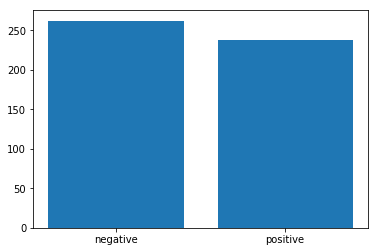

In [135]:
plt.bar(groupEmotion.index, groupEmotion)

In [136]:
#Every word is converted into a feature using a simplified bag of words model:
def words(stringIterable):
    lineStream = iter(stringIterable)
    for line in lineStream: #enumerate the lines
        for word in line.split(): #further break them down
            yield word

listepos = []
listeneg = []
for word in data.processed_data.comment:
    #print(word)
    for w in words([word]):
        print(w)

عسلامة
أورونج
رقدت
مخلي
ال
puce
متاعي
أورونج
قمت
نلقاها
تبدلت
أوريدو
بلاهي
كيفاش
نبدلها
تليكوم
اورونج
نحب
نقلكم
عيشكم
خاتر
انتوما
الوحدين
تتفكروني
تعيدو
عليا
قبل
عيلتي
و
مبعد
تبعثولي
ميساج
تقولولي
راهو
فلوسك
وفاو
تعرف
الي
انا
مبارح
صبيت
دينار
ياخي
سرقتوه
تعرفووووو...😠😠
مصح
الرقعة
😑
كان
جيت
انجم
نقتل
واحد
راني
مشيت
طول
انلوج
الي
يبعثلي
مساج
يقلي
فيه
راهو
فلوسك
وفاو😈
و
شكرا
.....
من
دون
تصفيق
😂😂
brabi
orange,
pk
l'connexion
,ma@
t7ebech
temchili
kan
fcbk
7ata
le
messenger
ma
najemtech
na3mlelha
téléchargement
en
plus
le
play
store
ma
7abech
chniya
ilmochkla
brabi
slm
orange
elyoum
3adet
fourfi
900
ta3
7
jour
tan7tli
1800
maya
a3lech
na7touhem
dima
tasrli
hadi
N7eb
orange
حزين
نسالكم
70
ميغاا
الله
لا
تربحكم
انتم
باش
تربحوو
الشعب
يا
متحيلين
ان
شاء
الله
70
ميغاا
تطلعلكم
70
مليار
خسارة
Problème
de
connexion
avec
les
sites
internationaux
en
4G
!!!
echnouwa
hedha!
echnouwa
ye5i
Facebook,
Youtube
,
twitter
welbe9i
ma3andenech
el7a9??!!
bon
orange
pk
la
connexion
t7bch
temchi
ken
facebook
ama
yo

AttributeError: 'float' object has no attribute 'split'

In [184]:
import re

In [201]:
class TwitterData_TokenStem(TwitterData_Cleansing):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        
    def stem(self, stemmer=nltk.PorterStemmer()):
        def stem_and_join(row):
            row["comment"] = list(map(lambda str: stemmer.stem(str.lower()), row["comment"]))
            return row

        self.processed_data = self.processed_data.apply(stem_and_join, axis=1)

    def tokenize(self, tokenizer=nltk.word_tokenize):
        def tokenize_row(row):
            row["comment"] = tokenizer(row["comment"])
            row["tokenized_text"] = [] + row["comment"]
            return row
    def custom_tokenize(self, tokenizer=nltk.word_tokenize):
        def tokenize_row(row):
            if not row["comment"]:
                print('The text to be tokenized is a None type. Defaulting to blank string.')
                row["comment"] = ''
                return row
            df['tokenized_column'] = df.column.apply(custom_tokenize)

        self.processed_data = self.processed_data.apply(tokenize_row, axis=1)

In [202]:
data = TwitterData_TokenStem(data)
#data.custom_tokenize()

In [203]:
data = TwitterData_TokenStem(data)
#data.tokenize()
#data.stem()
data.processed_data.head(5)

,idx,comment,emotion,date,url
0,0,عسلامة أورونج رقدت مخلي ال puce متاعي أورونج ق...,negative,2018-01-02T19:16:17+0000,https://www.facebook.com/298166859034_10155976...
1,1,اورونج نحب نقلكم عيشكم خاتر انتوما الوحدين\nتت...,negative,2018-01-02T19:43:48+0000,https://www.facebook.com/298166859034_10155976...
2,2,brabi orange pk lconnexion ma tebech temchili ...,negative,2018-01-02T20:37:47+0000,https://www.facebook.com/298166859034_10155976...
3,3,slm orange elyoumadet fourfi ta jour tantli ma...,negative,2018-01-02T19:00:49+0000,https://www.facebook.com/298166859034_10155976...
4,4,Neb orange,positive,2018-01-08T20:13:49+0000,https://www.facebook.com/298166859034_10155991...


In [204]:
words = Counter()
for idx in data.processed_data.index:
    words.update(data.processed_data.loc[idx, "comment"])

words.most_common(5)

TypeError: 'float' object is not iterable

In [205]:
class TwitterCleanuper:
    def iterate(self):
        for cleanup_method in [self.remove_urls,
                               self.remove_usernames,
                               self.remove_na,
                               self.remove_special_chars,
                               self.remove_numbers]:
            yield cleanup_method
    @staticmethod
    def remove_by_regex(tweets, regexp):
        tweets.loc[:, "comment"].replace(regexp, "", inplace=True)
        return tweets

    def remove_urls(self, tweets):
        return TwitterCleanuper.remove_by_regex(tweets, regex.compile(r"http.?://[^\s]+[\s]?"))

    def remove_na(self, tweets):
        return tweets[tweets["comment"] != "Not Available"]

    def remove_special_chars(self, tweets):  # it unrolls the hashtags to normal words
        for remove in map(lambda r: regex.compile(regex.escape(r)), [",", ":", "\"", "=", "&", ";", "%", "$",
                                                                     "@", "%", "^", "*", "(", ")", "{", "}",
                                                                     "[", "]", "|", "/", "\\", ">", "<", "-",
                                                                     "!", "?", ".", "'",
                                                                     "--", "---", "#"]):
            tweets.loc[:, "comment"].replace(remove, "", inplace=True)
        return tweets

    def remove_usernames(self, tweets):
        return TwitterCleanuper.remove_by_regex(tweets, regex.compile(r"@[^\s]+[\s]?"))

    def remove_numbers(self, tweets):
        return TwitterCleanuper.remove_by_regex(tweets, regex.compile(r"\s?[0-9]+\.?[0-9]*"))

In [206]:
class TwitterData_Cleansing(Data_Initialize):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        
    def cleanup(self, cleanuper):
        t = self.processed_data
        for cleanup_method in cleanuper.iterate():
            if not self.is_testing:
                t = cleanup_method(t)
            else:
                if cleanup_method.__name__ != "remove_na":
                    t = cleanup_method(t)

        self.processed_data = t

In [207]:
data = TwitterData_Cleansing(data)
data.cleanup(TwitterCleanuper())
data.processed_data.head(10)

,idx,comment,emotion,date,url
0,0,عسلامة أورونج رقدت مخلي ال puce متاعي أورونج ق...,negative,2018-01-02T19:16:17+0000,https://www.facebook.com/298166859034_10155976...
1,1,اورونج نحب نقلكم عيشكم خاتر انتوما الوحدين\nتت...,negative,2018-01-02T19:43:48+0000,https://www.facebook.com/298166859034_10155976...
2,2,brabi orange pk lconnexion ma tebech temchili ...,negative,2018-01-02T20:37:47+0000,https://www.facebook.com/298166859034_10155976...
3,3,slm orange elyoumadet fourfi ta jour tantli ma...,negative,2018-01-02T19:00:49+0000,https://www.facebook.com/298166859034_10155976...
4,4,Neb orange,positive,2018-01-08T20:13:49+0000,https://www.facebook.com/298166859034_10155991...
5,5,حزين,negative,2018-01-08T19:15:36+0000,https://www.facebook.com/298166859034_10155991...
6,6,نسالكم ميغاا الله لا تربحكم انتم باش تربحوو ال...,negative,2018-01-02T19:11:40+0000,https://www.facebook.com/298166859034_10155976...
7,7,Problème de connexion avec les sites internati...,negative,2018-01-09T18:10:08+0000,https://www.facebook.com/298166859034_10155990...
8,8,bon orange pk la connexion tbch temchi ken fac...,negative,2018-01-02T20:47:32+0000,https://www.facebook.com/298166859034_10155976...
9,9,aslma orange belhy neb nareflach neetow barcha...,negative,2018-01-02T21:43:12+0000,https://www.facebook.com/298166859034_10155976...


In [143]:
#df = pd.read_csv('data\\four-column500v1.2.csv', sep=',')

In [144]:
#x = pd.read_table('path to csv', sep=',')

In [152]:
col_name =df.columns[0]
col_name

'idx'

In [220]:
class TwitterData_TokenStem(TwitterData_Cleansing):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        
    def stem(self, stemmer=nltk.PorterStemmer()):
        def stem_and_join(row):
            row["emotion"] = list(map(lambda str: stemmer.stem(str.lower()), row["emotion"]))
            return row

        self.processed_data = self.processed_data.apply(stem_and_join, axis=1)

    def tokenize(self, tokenizer=nltk.word_tokenize):
        def tokenize_row(row):
            row["emotion"] = tokenizer(row["emotion"])
            row["tokenized_text"] = [] + row["emotion"]
            return row

        self.processed_data = self.processed_data.apply(tokenize_row, axis=1)

In [221]:
data = TwitterData_TokenStem(data)
data.tokenize()
data.stem()
data.processed_data.head(5)

TypeError: ('expected string or bytes-like object', 'occurred at index 0')

In [ ]:
words = Counter()
for idx in data.processed_data.idx:
    words.update(data.processed_data.loc[idx, "emotion"])
    words.most_common(5)

In [211]:
nltk.word_tokenize('في_بيتنا كل شي لما تحتاجه يضيع ...ادور على شاحن فجأة يختفي ..لدرجة اني اسوي نفسي ادور شيء ')

['في_بيتنا',
 'كل',
 'شي',
 'لما',
 'تحتاجه',
 'يضيع',
 '...',
 'ادور',
 'على',
 'شاحن',
 'فجأة',
 'يختفي',
 '..لدرجة',
 'اني',
 'اسوي',
 'نفسي',
 'ادور',
 'شيء']